In [73]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import lambda2nu, nu2lambda, c

In [74]:
# lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
lumapi = imp.load_source("lumapi", lumapiFile)
varApi = lumapi.MODE(hide = False)

##  Specification of the materials and dimensions of the guide

In [75]:
# units
um = 1e-6
nm = 1e-9

In [76]:
# Materials 
sub_material = 'SiO2 (Glass) - Palik'
core_material = 'Si (Silicon) - Palik'

In [77]:
# MMI x parameters
# L = 57.42 * um
L = 59.2*um # otimizado
W = 7.0 * um

# Taper parameters
W1 = 450 * nm
W2 = 1.5 * um
L1 = 15 * um

# Waveguide parameters
wvg_width = 450 * nm
wvg_height = 220 * nm

# Waveguide length
wvg_length = 4.0 * um

# Bandwidth operation
cband = True
filename = "S_MMI_varFDTD_2x2_%d_um" % (L / um)

# C Band simulation: 1520 - 1575 nm
# L Band simulation: 1555 - 1635 nm


if cband:
    wvlngth_start = 1.520 * um
    wvlngth_stop = 1.575 * um
else:
    wvlngth_start = 1.555 * um
    wvlngth_stop = 1.635 * um

nmbrFrqPnts = 20


## Structure creation

In [78]:
# Defining a Structure Group
varApi.addstructuregroup()
dev_layer = "GDS_LAYER 35:4"
varApi.set("name", dev_layer)

In [79]:
varApi.switchtolayout()
varApi.deleteall()

# Add box
varApi.addrect()
varApi.addtogroup(dev_layer)
varApi.set("name", "box")
varApi.set("x", 0)
varApi.set("x span", L)
varApi.set("y", 0)
varApi.set("y span", W)
varApi.set("z", 0)
varApi.set("z span", wvg_height)
varApi.set("material", core_material)

# Tapers Configuration
for i in range(4):
    varApi.addobject("linear_taper")
    varApi.set("name", f"taper port {str(i + 1)}")
    varApi.set("thickness", wvg_height)
    varApi.set("angle_side", 90)
    varApi.set("width_r", W1)
    varApi.set("width_l", W2)
    varApi.set("len", L1)
    varApi.set("material", core_material)
    varApi.set("x", varApi.getnamed(f"{dev_layer}::box", "x max") + L1/2)
    varApi.set("y", 0)
    varApi.set("z", 0)

# Adjusting taper positions
varApi.select(f"{dev_layer}::taper port 1")
varApi.set("width_r", W2)
varApi.set("width_l", W1)
varApi.set("x", -varApi.getnamed(f"{dev_layer}::box", "x max") - L1/2)
varApi.set("y", W/6)

varApi.select(f"{dev_layer}::taper port 2")
varApi.set("width_r", W2)
varApi.set("width_l", W1)
varApi.set("x", -varApi.getnamed(f"{dev_layer}::box", "x max") - L1/2)
varApi.set("y", -W/6)

varApi.select(f"{dev_layer}::taper port 3")
varApi.set("y", W/6)

varApi.select(f"{dev_layer}::taper port 4")
varApi.set("y", -W/6)

# add waveguides
for i in range(4):
    varApi.addrect()
    varApi.addtogroup(dev_layer)
    varApi.set("name", f"wvguide {str(i+1)}")
    varApi.set("x", 0)
    varApi.set("x span", wvg_length)
    varApi.set("y", 0)
    varApi.set("y span", wvg_width)
    varApi.set("z", 0)
    varApi.set("z span", wvg_height)
    varApi.set("material", core_material)

# Adjusting the wvg positions
varApi.select(f"{dev_layer}::wvguide 1")
varApi.set("x", varApi.getnamed(f"{dev_layer}::box", "x min") - L1 - wvg_length/2)
varApi.set("y", W/6)

varApi.select(f"{dev_layer}::wvguide 2")
varApi.set("x", varApi.getnamed(f"{dev_layer}::box", "x min") - L1 - wvg_length/2)
varApi.set("y", -W/6)

varApi.select(f"{dev_layer}::wvguide 3")
varApi.set("x", varApi.getnamed(f"{dev_layer}::box", "x max") + L1 + wvg_length/2)
varApi.set("y", W/6)

varApi.select(f"{dev_layer}::wvguide 4")
varApi.set("x", varApi.getnamed(f"{dev_layer}::box", "x max") + L1 + wvg_length/2)
varApi.set("y", -W/6)

## Add solver

In [80]:

xspan_solver = L + L1*2 + wvg_length*1.75
yspan_solver = W * 1.5
zspan_solver = wvg_height*4
number_points = 20

test_points = np.array([[-L/2, W/2 + 0.5*um],
                        [L/2, -(W/2 + 0.5*um)],
                        [L/2, W/2 + 0.5*um],
                        [-L/2, -(W/2 + 0.5*um)]])

In [81]:
varApi.switchtolayout()
varApi.select('varFDTD')
varApi.delete()

varApi.addvarfdtd()
varApi.set('x', 0)
varApi.set('y', 0)
varApi.set('z', 0)
varApi.set("x span",xspan_solver)
varApi.set("y span",yspan_solver)
varApi.set("z span",zspan_solver)
varApi.set('x0', -L/2)
varApi.set('y0', W/6)
varApi.set('background material', sub_material)
varApi.set('global monitor frequency points', number_points)
varApi.set('test points', test_points)
varApi.set('mesh accuracy', 2)

varApi.set('z min bc', 'Symmetric' )
varApi.set('z max bc', 'PML' )

## Add Source


In [82]:
varApi.switchtolayout()
varApi.select('source_input')
varApi.delete()

varApi.addmodesource()
varApi.set('name', 'source_input')
varApi.set('injection axis', 'x')
varApi.set('x', -(L/2 + L1 + wvg_length - 1*um))
varApi.set('y', W/6)
varApi.set("y span", wvg_width*4)
varApi.set('wavelength start', wvlngth_start)
varApi.set('wavelength stop', wvlngth_stop)
varApi.set('direction', 'forward')


## Add monitors

In [83]:
varApi.switchtolayout()
for i in range(5):
    varApi.select('monitor_' + str(i))
    varApi.delete()


varApi.addprofile()
varApi.set('name', 'monitor_0')
varApi.set('x', 0)
varApi.set('y', 0)
varApi.set("x span", xspan_solver)
varApi.set("y span", yspan_solver)

for j in range(4):

    varApi.addpower()
    varApi.set('name', 'monitor_' + str(j + 1))
    varApi.set('monitor type', 5)
    varApi.set('x', -(L/2 + L1 + wvg_length - 1.6*um))
    varApi.set('y', (W/6) * (-1)**j)
    varApi.set('y span', wvg_width*4)
    varApi.set('z span', zspan_solver)

varApi.select('monitor_3')
varApi.set('x', (L/2 + L1 + wvg_length - 1.6*um))

varApi.select('monitor_4')
varApi.set('x', (L/2 + L1 + wvg_length - 1.6*um))

## Simulation

In [84]:
varApi.save(f"C:/Users/alves/Documents/{filename}")

varApi.run()

In [97]:
Ex = varApi.getresult("monitor_0", "Ex")
Ey = varApi.getresult("monitor_0", "Ey")

x = varApi.getresult("monitor_0", "x")
y = varApi.getresult("monitor_0", "y")

x = x[:,0]/um
y = y[:,0]/um

Emag = np.sqrt(np.abs(Ex**2) + np.abs(Ey**2))

print(x)

[-48.1        -48.05631244 -48.01262489 ...  48.01262489  48.05631244
  48.1       ]


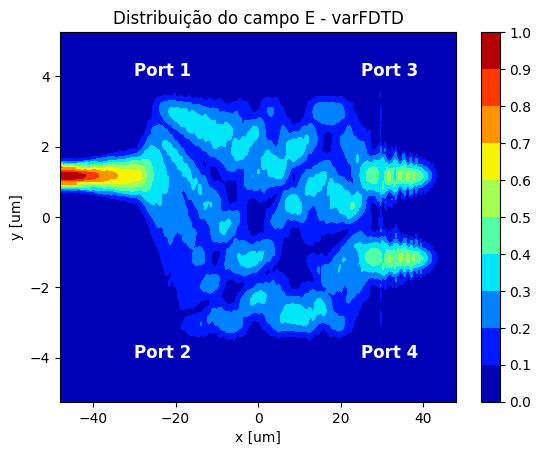

In [123]:
plt.figure()
mycmap = plt.get_cmap('jet')

v = np.linspace(0, 1, 11, endpoint=True)
plt.contourf(x, y, np.transpose(Emag[:,:, 0, 19]), v, cmap=mycmap)
plt.colorbar(ticks=v)

plt.title('Distribuição do campo E - varFDTD', fontsize=12)
plt.ylabel('y [um]', fontsize=10)
plt.xlabel('x [um]', fontsize=10)

plt.text(-30, 4, 'Port 1', fontsize=12, fontweight='bold', color='w')
plt.text(-30, -4, 'Port 2', fontsize=12, fontweight='bold', color='w')
plt.text(25, -4, 'Port 4', fontsize=12, fontweight='bold', color='w')
plt.text(25, 4, 'Port 3', fontsize=12, fontweight='bold', color='w')

plt.savefig('Campo_E_var')


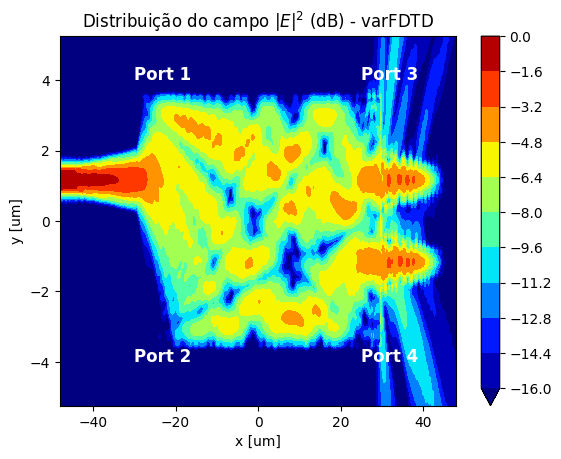

In [122]:
plt.figure()
v = np.linspace(-16, 0, 11, endpoint=True)

plt.title("Distribuição do campo $|E|^2$ (dB) - varFDTD", fontsize=12)
plt.ylabel("y [um]", fontsize=10)
plt.xlabel("x [um]", fontsize=10)

CS = plt.contourf(x, y, 10*np.log10(np.transpose(Emag[:,:,0,10])), v, cmap=mycmap, extend='min')
plt.colorbar(ticks=v)

plt.text(-30, 4, 'Port 1', fontsize=12, fontweight='bold', color='w')
plt.text(-30, -4, 'Port 2', fontsize=12, fontweight='bold', color='w')
plt.text(25, -4, 'Port 4', fontsize=12, fontweight='bold', color='w')
plt.text(25, 4, 'Port 3', fontsize=12, fontweight='bold', color='w')

plt.savefig('Campo_E_log_var')